In [1]:
# General Imports
import numpy as np
import csv
from datetime import datetime as time
import os

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
# TeX Label Config
import matplotlib as mpl
mpl.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': 'cmr10',
    'mathtext.fontset': 'cm',
    'font.family': 'STIXGeneral',
    'font.size': 12,
    'axes.unicode_minus': True,
    'figure.autolayout': True,
    'legend.fontsize': 'large'
    })

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.model_selection import train_test_split

# tqdm for progress bar
from tqdm import trange, tqdm

# ipython config
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Global definitions

In [2]:
def plot_dm(astate, title=''):

    # Init arrays
    dim = astate.shape[0]
    dz = astate.ravel()
    xpos, ypos = np.meshgrid(np.arange(dim), np.arange(dim))
    xpos = xpos.ravel()
    ypos = ypos.ravel()


    fig = plt.figure(dpi=80)

    # Init colorbar
    cmap = cm.get_cmap('plasma')
    norm = Normalize(vmin=min(dz), vmax=max(dz))
    colors = cmap(norm(dz))

    # 2D color plot
    ax = fig.add_subplot(5,7,(12,28))
    ax.imshow(astate, vmin=min(dz), vmax=max(dz), cmap=cmap)
    a=ax.set_xticks(xpos)
    a=ax.set_yticks(ypos)
    a=sc = cm.ScalarMappable(cmap=cmap,norm=norm)
    a=sc.set_array([])
    a=plt.colorbar(sc)


    # Classical 3D density matrix plot
    ax = fig.add_subplot(5,7,(1,32), projection='3d')
    a=ax.bar3d(x=xpos-.25, y=ypos-.25, z=0, dx=0.5, dy=0.5, dz=dz, color=colors)
    a=ax.set_xticks(xpos)
    a=ax.set_yticks(ypos)
    a=ax.set_zticks([])
    a=ax.set_zlim(-max(dz), max(dz))
    a=ax.grid(False)
    #Plot grid on z=0
    for i in range(dim):
        a=ax.plot(i*np.ones(dim), np.arange(dim), 0, color='k', lw=.5)
        a=ax.plot(np.arange(dim), i*np.ones(dim), 0, color='k', lw=.5)

    if title != '':
        fig.suptitle(title)
    plt.show()

# State Generator

## Pure states

In [3]:
# Adapted for vector from unitary group
from scipy.stats import unitary_group

def create_pure_rho(nqubits):
    dim = 2**nqubits
    psi = unitary_group.rvs(dim)[0]
    # psi =   np.random.uniform(low=-1, high=1, size=dim) + 1j * np.random.uniform(low=-1, high=1, size=dim) 
    rho = np.outer(psi, psi.T.conjugate())
    
    #Positive-definiteness given due to outer product above
    # Trace condition
    rho /= np.trace(rho)
    return rho

In [4]:
# Test Trace nqubits=4
n = 100
print('Traces of 100 test 1qubit states squared = 1?')
traces = np.array([create_pure_rho(nqubits=4) for _ in range(n)])
traces = np.array([np.trace(np.real(rho.dot(rho))) for rho in traces])
np.all( (traces-1) < 1e-10 )

Traces of 100 test 1qubit states squared = 1?


True

## Mixed States

### Partial trace method

array([[0.34468529+0.j        , 0.04505975-0.02671571j,
        0.09258565+0.17314093j, 0.04372781-0.04139492j],
       [0.04505975+0.02671571j, 0.17419094+0.j        ,
        0.12103062-0.07172873j, 0.04744465-0.12329632j],
       [0.09258565-0.17314093j, 0.12103062+0.07172873j,
        0.34944426+0.j        , 0.13419674-0.10918158j],
       [0.04372781+0.04139492j, 0.04744465+0.12329632j,
        0.13419674+0.10918158j, 0.13167951+0.j        ]])

(0.9999999999999999+0j)

(0.5127920912601963+2.0913483915529837e-18j)

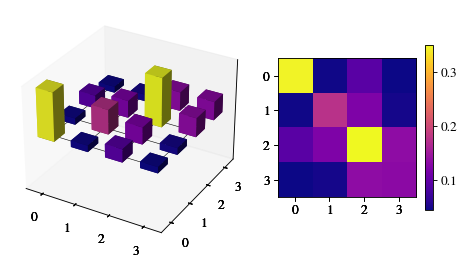

In [5]:
def partial_trace(rho):
    #trace is independent of basis choice of traced subsystem
    basis = np.eye(4)
    reduced = np.zeros((4,4), dtype=np.complex128)
    for bvec in basis:
        bra = np.kron(np.eye(4), bvec)
        reduced += bra.dot(rho.dot(bra.T))
    return reduced

# Wrapper function
def random_rho(pure):
    if pure:
        return create_pure_rho(nqubits=2)
    else:
        return partial_trace(create_pure_rho(nqubits=4))

# Test 
reduced = random_rho(pure=False)
reduced
np.trace(reduced)
# Tr(rho^2)
np.trace(reduced.dot(reduced))

plot_dm(np.real(reduced))

In [6]:
np.round(random_rho(pure=False),2)

array([[ 0.22+0.j  ,  0.14+0.j  , -0.02+0.09j,  0.02-0.01j],
       [ 0.14-0.j  ,  0.56+0.j  ,  0.22-0.05j,  0.03-0.01j],
       [-0.02-0.09j,  0.22+0.05j,  0.2 +0.j  , -0.  +0.01j],
       [ 0.02+0.01j,  0.03+0.01j, -0.  -0.01j,  0.02+0.j  ]])

### Bloch vector method

## Trace Distributions

### Mixed states from partial trace

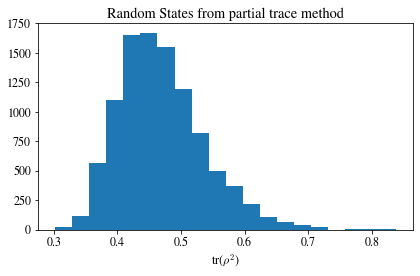

In [7]:
n = 10000
traces = np.array([random_rho(pure=False) for _ in range(n)])
traces = np.array([np.trace(rho.dot(rho)) for rho in traces])
a=plt.hist(np.real(traces), bins=20)
a=plt.xlabel('tr($\\rho^2$)')
a=plt.title('Random States from partial trace method')

# Measurement
using random states generated by partial trace method

## Create random set of observables

Goal: overcomplete measurements that allow full determination of rho from random observables

In [8]:
def create_random_obs(pure, n=100):
    assert n > 1, 'cannot sum up set of measurements to identity'
    # n = number of distinct measurements
    random_obs = np.array([random_rho(pure=pure) for _ in range(n)])

    # # For POVM
    #  All matrices generated by random_mixed_1qubit() are positive semidifinite
    # # sum(obs) == identity !
    # last_obs = np.eye(2) - np.sum(random_obs, axis=0)
    # random_obs = np.vstack((random_obs, np.array([last_obs])))
    
    return random_obs

def perform_measurements(rho, observables):
    return np.real( np.trace(observables.dot(rho), axis1=1, axis2=2) )

mean = 0.2501418451327813
std = 0.05219201730212076


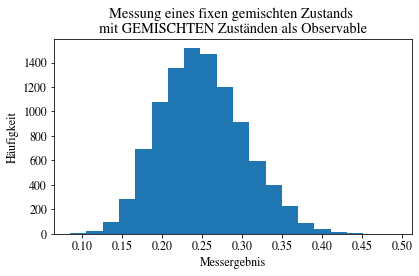

In [9]:
base_state = random_rho(pure=False)
observables = create_random_obs(pure=False, n=10000)

meas = perform_measurements(base_state, observables)
print('mean =', meas.mean())
print('std =', meas.std())

a=plt.hist(meas, bins=20)
a=plt.title('Messung eines fixen gemischten Zustands \nmit GEMISCHTEN Zuständen als Observable')
a=plt.xlabel('Messergebnis')
a=plt.ylabel('Häufigkeit')
#a=plt.xlim(0,1)

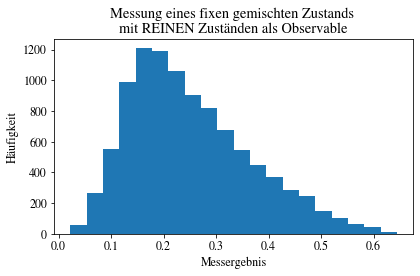

In [10]:
base_state = random_rho(pure=False)
observables = create_random_obs(pure=True, n=10000)

meas = perform_measurements(base_state, observables)


a=plt.hist(meas, bins=20)
a=plt.title('Messung eines fixen gemischten Zustands \nmit REINEN Zuständen als Observable')
a=plt.xlabel('Messergebnis')
a=plt.ylabel('Häufigkeit')

## Create Dataset

with same observables!

In [11]:
# Set parameters for new dataset
n_states = int(5e4)
n_observables = 100
observables = create_random_obs(pure=True, n=n_observables)
states = np.array([random_rho(pure=False) for _ in range(n_states)])

In [12]:
# timestamp = time.now().strftime("%Y%m%d_%H%M%S")
# PARENTPATH = f"./data/2qubit_pureobs_unitarygroup/states{n_states}_obs{n_observables}_{timestamp}/"
# os.mkdir(PARENTPATH)

# # Write out states
# with open(PARENTPATH + 'states.csv', 'w') as f:
#   writer = csv.writer(f)
#   for state in tqdm(states):
#     a=writer.writerow(state.reshape(16))
    
# # Write out observables
# with open(PARENTPATH + 'observables.csv', 'w') as f:
#   writer = csv.writer(f)
#   for obs in tqdm(observables):
#     a=writer.writerow(obs.reshape(16))

# # Write out measurements 
# with open(PARENTPATH + 'measurements.csv', 'w') as f:
#   writer = csv.writer(f)
#   for state in tqdm(states):
#     a=writer.writerow(perform_measurements(state, observables))

# FFN Tomography

### Prepare dataset

In [13]:
# Retrieve independent values from density matrix

## Treat complex numbers as 2 independent floating numbers for processing in network
## Processing complex units is not yet implemented to pytorch

def rho2torch(rho):
    dim = 4
    rho = rho.reshape(4,4)
    diags = np.array([np.real(rho[i,i]) for i in range(dim-1)])
    ur = np.array([])
    for i in range(dim-1):
        ur = np.hstack((ur, rho[i][i+1:dim]))
    ur = np.hstack((np.real(ur), np.imag(ur)))
    return np.hstack((diags, ur))

def torch2rho(tensor):
    diag_coeff = np.array(tensor[:3])
    norm_coeff = 1 - np.sum(diag_coeff)
    diags = np.hstack((diag_coeff, norm_coeff))
    diags = np.diag(diags)

    ur_real = tensor[3:9]
    ur_imag = tensor[9:]
    ur = np.zeros((4,4), dtype='complex64')
    for i in range(6):
        for j in range(i+1, 4):
            ur[i,j] = ur_real[0] + 1.j* ur_imag[0]
            ur_real = np.delete(ur_real, 0)
            ur_imag = np.delete(ur_imag, 0)
    return diags + ur + ur.T.conjugate()

# Test
astate = np.round(random_rho(pure=False),2)
bstate = torch2rho(rho2torch(astate))
np.all((astate - bstate) < 1e10)

True

In [14]:
datadir = './data/2qubit_pureobs_unitarygroup/states50000_obs100_20220502_143300/'
nobs = 100

y = np.zeros((0,15))
X = np.zeros((0,nobs))
data_obs = np.zeros((0,4,4))

# Read states
with open(datadir+'states.csv', 'r') as f:
  reader = csv.reader(f)
  for line in tqdm(reader):
    state = np.array(np.array(line).astype('complex128'))
    y = np.vstack((y, rho2torch(state)))

# Read observables
with open(datadir+'observables.csv', 'r') as f:
  reader = csv.reader(f)
  for line in tqdm(reader):
    data_obs = np.vstack((data_obs, np.array([np.array(line).reshape(4,4).astype('complex128')])))

# Read states
with open(datadir+'measurements.csv', 'r') as f:
  reader = csv.reader(f)
  for line in tqdm(reader):
    X = np.vstack((X, np.array(np.array(line).astype('float'))))


X_train, X_left, y_train, y_left = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_valid, X_treasure, y_valid, y_treasure = train_test_split(
    X_left, y_left, test_size=0.4, random_state=42)

X.shape
y.shape
X_train.shape[0]
X_valid.shape[0]
X_treasure.shape[0]

50000it [00:10, 4792.72it/s] 
100it [00:00, 32187.12it/s]
50000it [01:11, 700.32it/s] 


(50000, 100)

(50000, 15)

35000

9000

6000

In [15]:
class CustomDataset(Dataset):

  def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

  def __len__(self):
        return len(self.X)

  def __getitem__(self, index):
        # Select sample
        X = self.X[index]

        # Load data and get label
        x = self.X[index]
        y = self.Y[index]

        return x, y

In [16]:
tomography_train_dataset = CustomDataset(X_train, y_train)
tomography_valid_dataset = CustomDataset(X_valid, y_valid)
tomography_treasure_dataset = CustomDataset(X_treasure, y_treasure)

In [17]:
# Define the batch size
BATCH_SIZE = 64

# Create data loaders from the datasets for the current task
# Setting drop_last=True does not consider the last batch in which there are less than BATCH_SIZE examples
tomography_train_dataloader = DataLoader(tomography_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
tomography_valid_dataloader = DataLoader(tomography_valid_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
tomography_treasure_dataloader = DataLoader(tomography_treasure_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

## Feed Forward Network

Measurement outcomes --> bloch representation of state

In [18]:
class FeedForwardNet(nn.Module):

  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
    nn.Linear(100, 64),
    nn.ReLU(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,15)
    )

  def forward(self, x):
    return self.layers(x)

## Training

In [19]:
def plot_train_stats(train_losses, valid_losses, batchsize):
    it_per_epoch = X_train.shape[0] // batchsize

    a=plt.figure(figsize=(10,4))
    a=plt.plot(train_losses, lw=2, label='Training Loss on current batch')
    a=plt.xlabel('Iterations')
    a=plt.ylabel('Loss')
    a=plt.yscale('log')
    a=plt.legend()
    a=plt.title(f'Loss on training set \t (MSE, 1 epoch = {it_per_epoch} iterations)')
    plt.show()

    a=plt.figure(figsize=(10,4))
    a=plt.plot(valid_losses, lw=2, label='Validation Loss on full validation set')
    a=plt.xlabel('Iterations')
    a=plt.ylabel('Loss')
    a=plt.yscale('log')
    a=plt.legend()
    a=plt.title(f'Loss (MSE) on Validation set  \t (MSE, 1 epoch = {it_per_epoch} iterations)')
    plt.show()

In [20]:
def evaluate_mse_ffn(net, dataloader, criterion, device):
    batch_loss = np.array([])
    for batch in dataloader:
        measurements, target = batch[0].to(device), batch[1].to(device)
        outputs = net(measurements)
        loss = criterion(outputs, target).clone().detach().cpu().numpy()
        batch_loss = np.append(batch_loss, loss)
    return np.mean(batch_loss)

In [21]:
# Function for training the network
def train(net, train_epochs, train_dataloader, valid_dataloader, optimizer, criterion):

    train_losses = np.array([])
    valid_losses = np.array([])

    for epoch in trange(train_epochs):
        net.train()
        for batch_idx, samples in enumerate(train_dataloader):
            data, target = samples[0].to(device), samples[1].to(device)
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_losses = np.append(train_losses, loss.clone().detach().cpu().numpy())

            # Check loss on validation set
            valid_losses = np.append(valid_losses, evaluate_mse_ffn(net, valid_dataloader, criterion, device))
    return train_losses, valid_losses

In [42]:
# Check if the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Create the network on the CPU/GPU
net = FeedForwardNet().to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

train_losses, valid_losses = train(net, 4, tomography_train_dataloader, tomography_valid_dataloader, optimizer, criterion)

cpu


100%|██████████| 4/4 [01:35<00:00, 23.95s/it]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


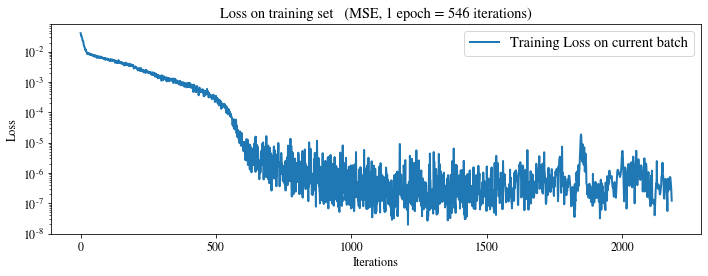

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


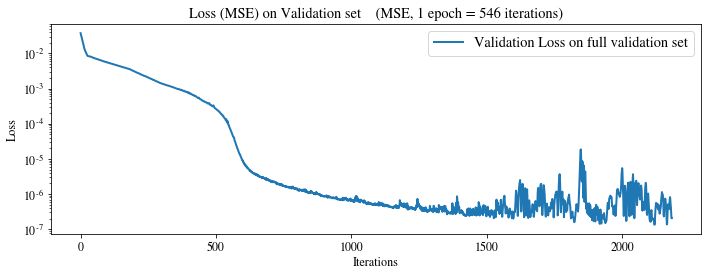

In [43]:
plot_train_stats(train_losses, valid_losses, BATCH_SIZE)

In [40]:
train_losses[-1]
valid_losses[-1]

1.414374651176331e-06

1.2057961449889783e-06

## Evaluation

performance on unseen data (treasure set)

comparison between untrained and trained net

In [41]:
print('Mean Square Error of on unseen data')
untrained_net = FeedForwardNet().to(device)
print('Untrained Net: ', evaluate_mse_ffn(
    untrained_net, tomography_treasure_dataloader, nn.MSELoss(),device))
print('Trained Net: ', evaluate_mse_ffn(
    net, tomography_treasure_dataloader, nn.MSELoss(), device))

Mean Square Error of on unseen data
Untrained Net:  0.027620088208907392
Trained Net:  1.3137681222478052e-06


## Inference

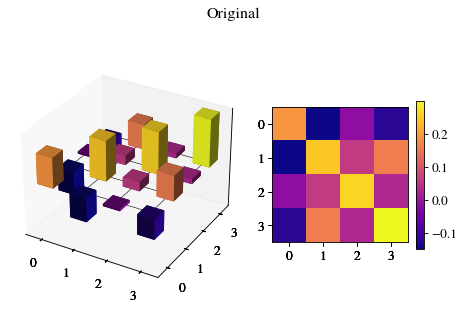

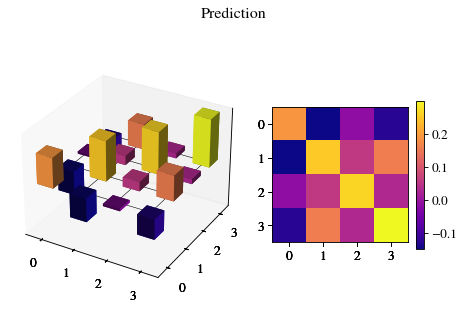

In [51]:
rho_infer = random_rho(pure=False)
m_infer = torch.Tensor(perform_measurements(rho_infer, data_obs))
tensor_pred = net(m_infer.to(device)).detach().cpu()
rho_pred = torch2rho(tensor_pred)

plot_dm(np.real(rho_infer), title='Original')
plot_dm(np.real(rho_pred), title='Prediction')

# AE Compact State Representations

## Autoencoder

In [205]:
class AutoencoderNet(nn.Module):

  def __init__(self, latent_size):
    super().__init__()

    self.latent_size = latent_size
    self.layer1_size = 64
    self.layer2_size = 32

    self.encoder = nn.Sequential(
    nn.Linear(100, self.layer1_size),
    nn.ReLU(),
    nn.Linear(self.layer1_size, self.layer2_size),
    nn.ReLU(),
    nn.Linear(self.layer2_size,self.latent_size),
    )

    self.decoder = nn.Sequential(
    nn.Linear(self.latent_size, self.layer2_size),
    nn.ReLU(),
    nn.Linear(self.layer2_size,self.layer1_size),
    nn.ReLU(),
    nn.Linear(self.layer1_size,100),
    )

  def forward(self, x):
    minrep = self.encoder(x)
    output = self.decoder(minrep)
    return output

## Training

In [206]:
def evaluate_mse_ae(net, dataloader, criterion, device):
    batch_loss = np.array([])
    for batch in dataloader:
        measurements = batch[0].to(device)
        outputs = net(measurements)
        loss = criterion(outputs, measurements).clone().detach().cpu().numpy()
        batch_loss = np.append(batch_loss, loss)
    return np.mean(batch_loss)

In [207]:
# Function for training the network
def ae_train(net, train_epochs, train_dataloader, valid_dataloader, optimizer, criterion):

    train_losses = np.array([])
    valid_losses = np.array([])

    for epoch in trange(train_epochs):
        net.train()
        for batch_idx, samples in enumerate(train_dataloader):
            data, target = samples[0].to(device), samples[1].to(device)
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)

            loss = criterion(outputs, data)
            

            loss.backward()
            optimizer.step()
            train_losses = np.append(train_losses, loss.clone().detach().cpu().numpy())

            # Check loss on validation set
            valid_losses = np.append(valid_losses, evaluate_mse_ae(net, valid_dataloader, criterion, device))

    return train_losses, valid_losses

In [208]:
def ae_train_eval(  latent_size, 
                    learning_rate, 
                    nepochs, 
                    train_dataloader, 
                    valid_dataloader, 
                    treasure_dataloader):

    # Create the network on the CPU/GPU
    ae_net = AutoencoderNet(latent_size=latent_size).to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ae_net.parameters(), lr=learning_rate)

    #Do training
    train_losses, valid_losses = ae_train(  ae_net, 
                                            nepochs, 
                                            train_dataloader, 
                                            valid_dataloader, 
                                            optimizer, 
                                            criterion)
    treasure_loss = evaluate_mse_ae(ae_net, treasure_dataloader, criterion, device)
    return net, train_losses, valid_losses, treasure_loss


100%|██████████| 30/30 [14:20<00:00, 28.68s/it]
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


AE Latent size = 32
MSE on unseen data: 3.6005561611013017e-06


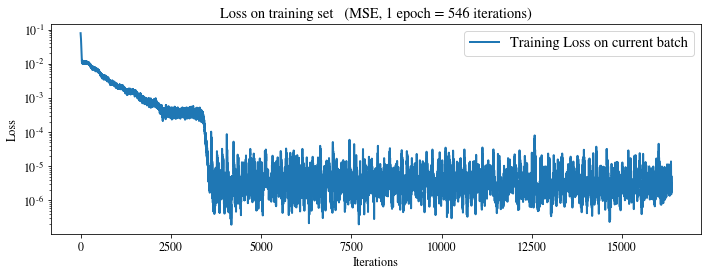

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


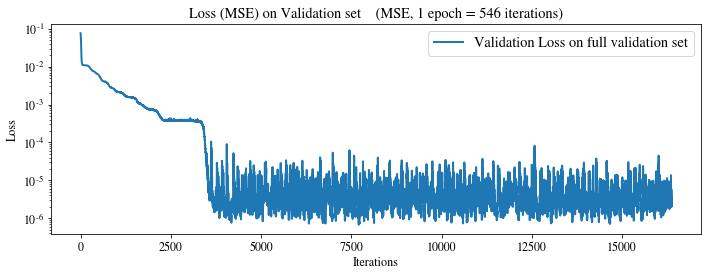

100%|██████████| 30/30 [1:37:44<00:00, 195.49s/it]   


AE Latent size = 15
MSE on unseen data: 2.006255585080018e-06


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


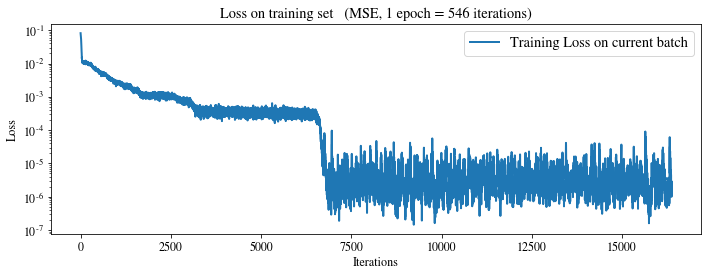

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


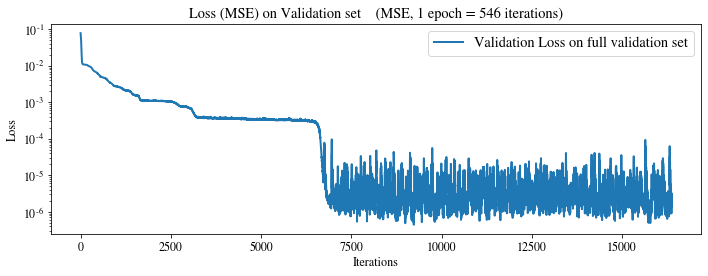

100%|██████████| 30/30 [14:18<00:00, 28.61s/it]
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


AE Latent size = 18
MSE on unseen data: 8.857981354580144e-07


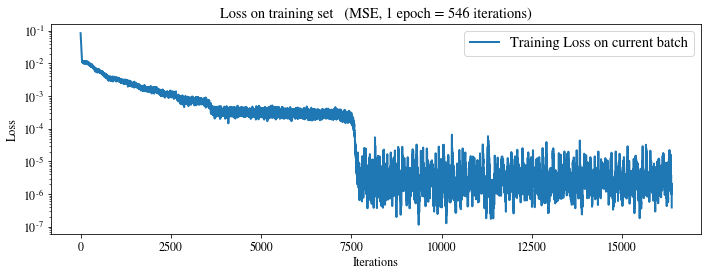

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


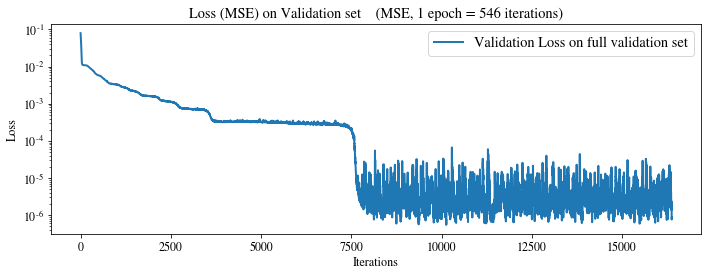

100%|██████████| 30/30 [14:17<00:00, 28.57s/it]
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


AE Latent size = 16
MSE on unseen data: 0.00022595616211483797


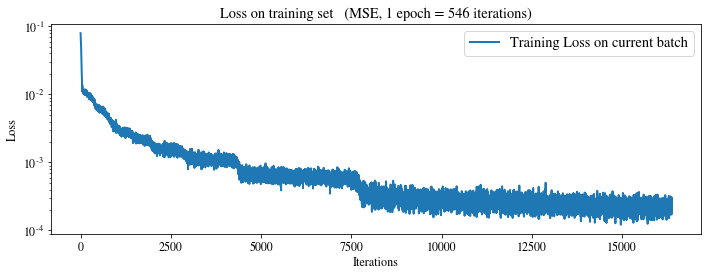

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


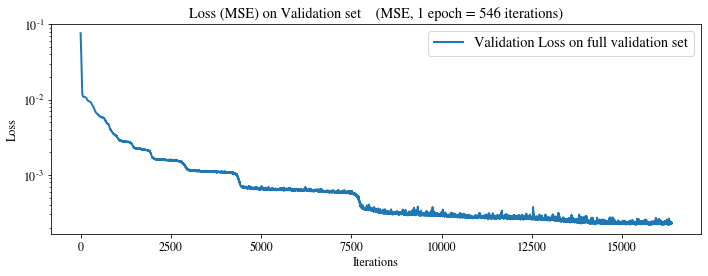

100%|██████████| 30/30 [14:13<00:00, 28.45s/it]


AE Latent size = 15
MSE on unseen data: 2.7959243623392408e-06


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


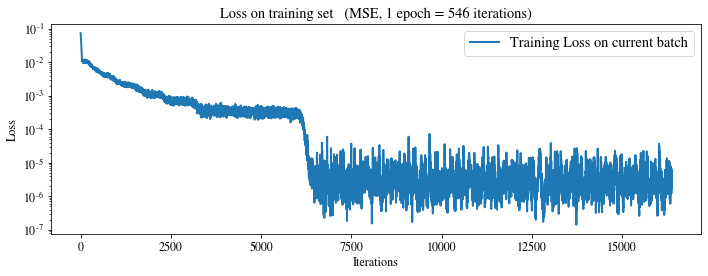

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


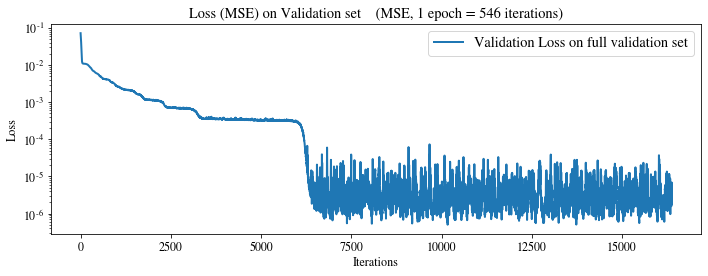

100%|██████████| 30/30 [1:01:33<00:00, 123.11s/it]
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


AE Latent size = 14
MSE on unseen data: 0.0003069508546945809


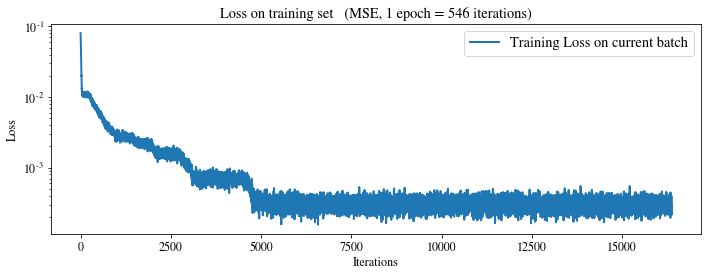

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


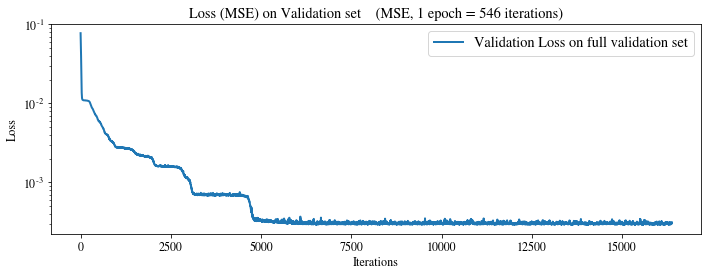

100%|██████████| 30/30 [13:43:00<00:00, 1646.02s/it]   
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


AE Latent size = 12
MSE on unseen data: 0.0009559024956517963


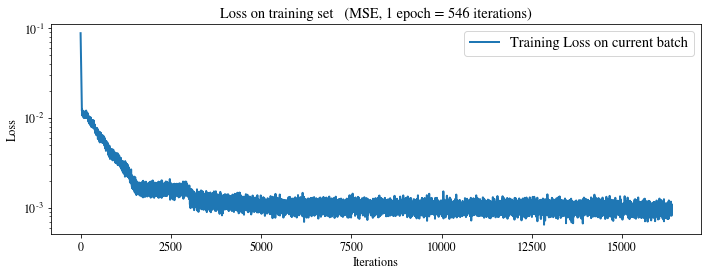

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


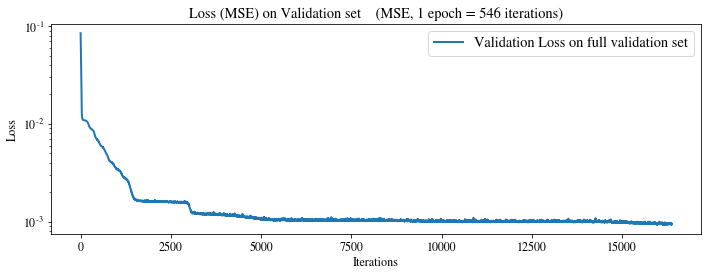

100%|██████████| 30/30 [16:54<00:00, 33.82s/it]
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


AE Latent size = 6
MSE on unseen data: 0.003368907663170048


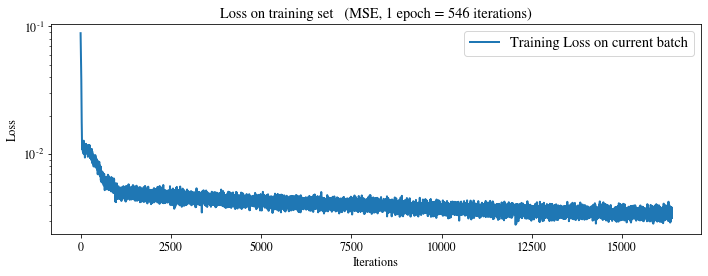

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


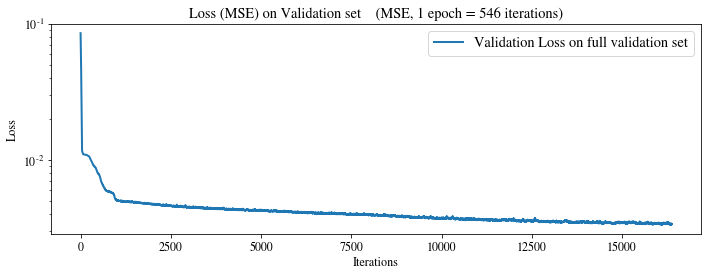

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
100%|██████████| 30/30 [14:05<00:00, 28.18s/it]
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


AE Latent size = 0
MSE on unseen data: 0.011096129824797954


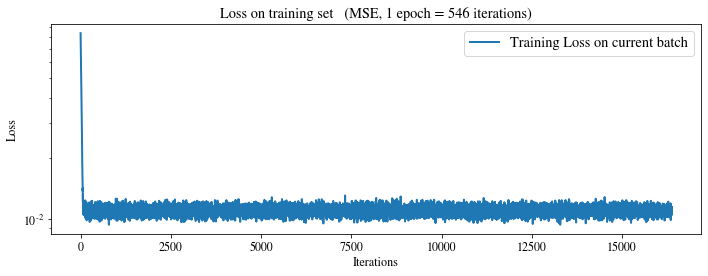

/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


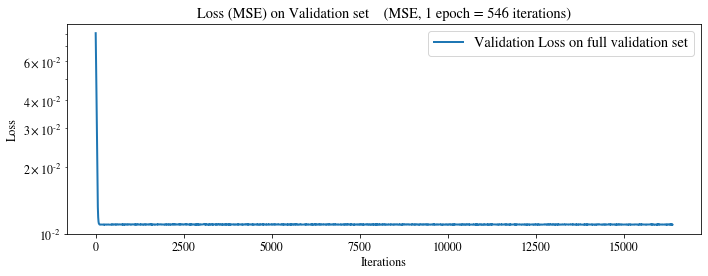

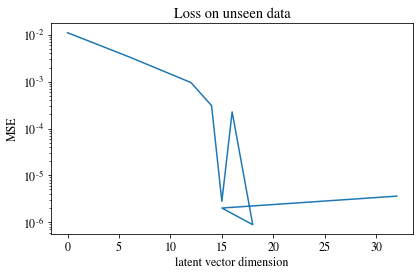

In [209]:
sizes = [32, 15, 18, 16, 15, 14, 12, 6, 0]
lr = 0.001
nepochs = 30

treasure_losses = np.array([])
for latent_size in sizes:
    _, train_losses, valid_losses, treasure_loss = ae_train_eval(   latent_size, 
                                                                    lr, 
                                                                    nepochs, 
                                                                    tomography_train_dataloader, 
                                                                    tomography_valid_dataloader, 
                                                                    tomography_treasure_dataloader)
    print(f'AE Latent size = {latent_size}')
    print(f'MSE on unseen data: {treasure_loss}')
    treasure_losses = np.append(treasure_losses, treasure_loss)
    plot_train_stats(train_losses, valid_losses, BATCH_SIZE)

a=plt.plot(sizes, treasure_losses)
a=plt.title('Loss on unseen data')
a=plt.ylabel('MSE')
a=plt.yscale('log')
a=plt.xlabel('latent vector dimension')


In [56]:
arr = [3.6005561611013017e-06,
8.857981354580144e-07,
8.857981354580144e-07,
2.7959243623392408e-06,
0.0003069508546945809,
0.0009559024956517963,
0.003368907663170048,
0.011096129824797954]

sizes = [32, 18, 16, 15, 14, 12, 6, 0]

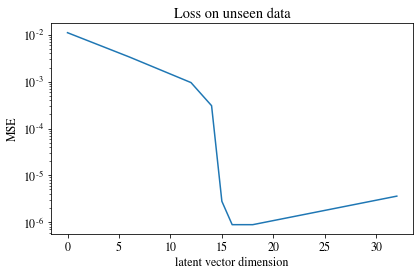

In [57]:
a=plt.plot(sizes, arr)
a=plt.title('Loss on unseen data')
a=plt.ylabel('MSE')
a=plt.yscale('log')
a=plt.xlabel('latent vector dimension')